# Face Detection Pipeline

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

# A. HOG Features:

* Histogram of Oriented Gradients (HOG)"
    * a feature extraction technique which transforms image pixels into a vector representation that is sensitive to broadly informative image features regardless of confounding factors like illumination.


* Steps:
    1. Optionally prenormalize the images. This leads to features that resist dependence on variations in illumination.
    2. Convolve the image with two filters that are sensitive to horizontal and vertical brightness gradients. These capture edge, contour, and texture information.
    3. Subdivide the image into cells of a predetermined size, and compute a histogram of the gradient orientations within each cell.
    4. Normalize the histograms in each cell by comparing to the block of neighboring cells. This further suppresses the effect of illumination across the image.
    5. Construct a one-dimensional feature vector from the information in each cell.

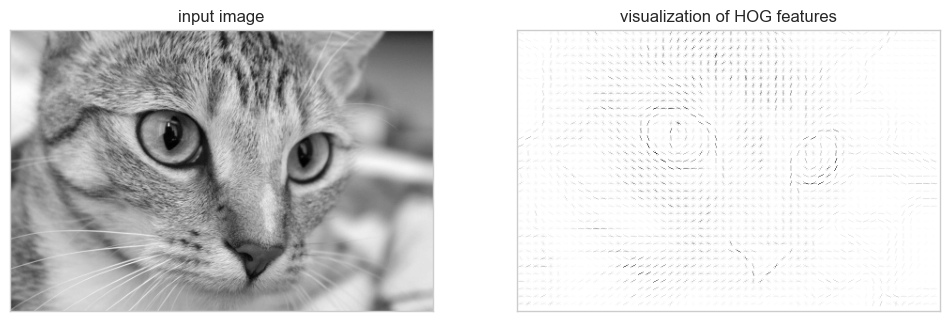

In [3]:
from skimage import data, color, feature
import skimage.data

image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualize=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(xticks=[], yticks=[]))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');

# B. HOG: A simple Face Detector:

* Using HOG features, we can build up a simple facial detection algorithm with any Scikit-Learn estimator.
* Steps ( using linear support vector machine):
    1. Obtain a set of image thumbnails of faces to constitute “positive” training samples.
    2. Obtain a set of image thumbnails of non-faces to constitute “negative” training samples.
    3. Extract HOG features from these training samples.
    4. Train a linear SVM classifier on these samples.
    5. For an “unknown” image, pass a sliding window across the image, using the model to evaluate whether that window contains a face or not.
    6. If detections overlap, combine them into a single window.

### B.1. Obtain a Set of Positive Training Samples:

* Find some positive training samples that show a variety of faces.

In [4]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

### B.2. Obtain a Set of Negative Training Samples

* Get similarly sized thumbnails that do not have a face in them..
* One way to obtain this is to take any corpus of input images, and extract thumbnails from them at a variety of scales.

In [5]:
data.camera().shape

(512, 512)

In [6]:
from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon', 'page', 'clock', 'immunohistochemistry','chelsea', 'coffee', 'hubble_deep_field']

raw_images = (getattr(data, name)() for name in imgs_to_use)
images = [color.rgb2gray(image) if image.ndim == 3 else image
            for image in raw_images]

In [7]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                                max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])

    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])

negative_patches.shape

(30000, 62, 47)

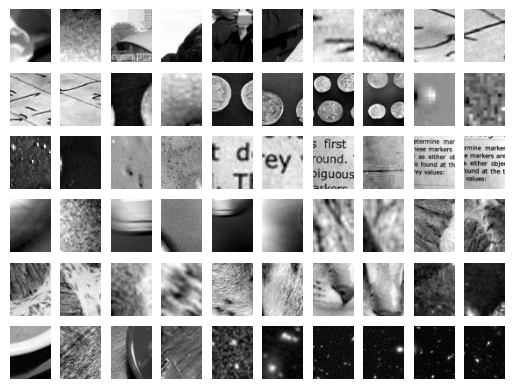

In [8]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')